In [36]:
# import required packages
import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.integrate import odeint

# import MAGI-X packages
from scripts.magix.dynamic import nnSTModule, nnMTModule # neural network module
from scripts.magix.inference import FMAGI # inferred module

### FitzHugh-Nagumo

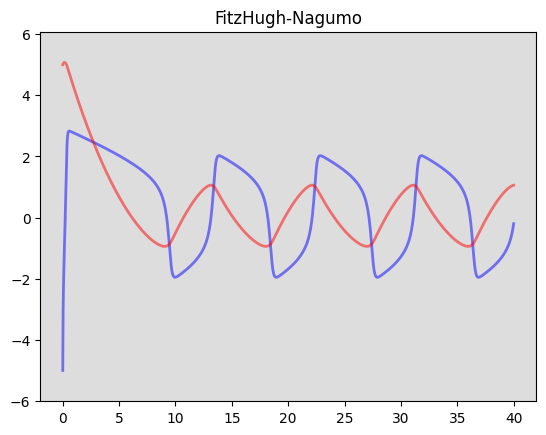

In [3]:
# define FitzHugh-Nagumo model dynamic
def FN(y, t, a, b, c):
	V, R = y
	dVdt = c * (V - np.power(V,3)/3.0 + R)
	dRdt = -1./c * (V - a + b*R)
	return (dVdt,dRdt)

# model parameters 
a, b, c = 0.2, 0.2, 3
# initial condition
V0 = -5
R0 = 5
y0 = V0, R0
# time point for evaluation
tdata = np.linspace(0, 40, 1281)
# integration
xdata = odeint(FN, y0, tdata, args = (a,b,c))
# visualization
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(tdata, xdata[:,0], 'b', alpha=0.5, lw=2, label='V')
ax.plot(tdata, xdata[:,1], 'r', alpha=0.5, lw=2, label='R')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('FitzHugh-Nagumo')
plt.show()

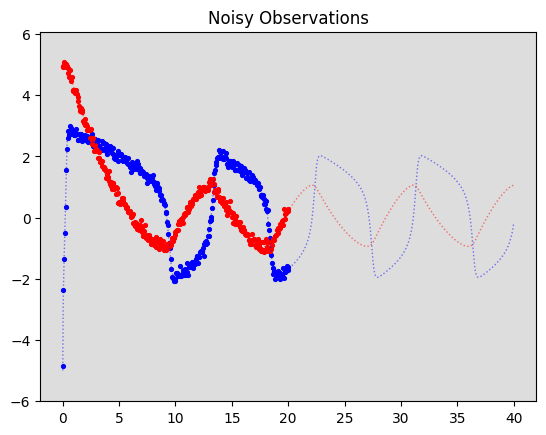

In [4]:
# setting
seed = 188714368 # random seed
noise = [0.1,0.1] # noise level
no_train = 321 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [5]:
# MAP Inference - Multi-task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 22.485630
200/1000 iteration: 5.734587
400/1000 iteration: 3.630648
600/1000 iteration: 2.828588
800/1000 iteration: 2.431090
1000/1000 iteration: 2.200450
run time: 20.51 seconds


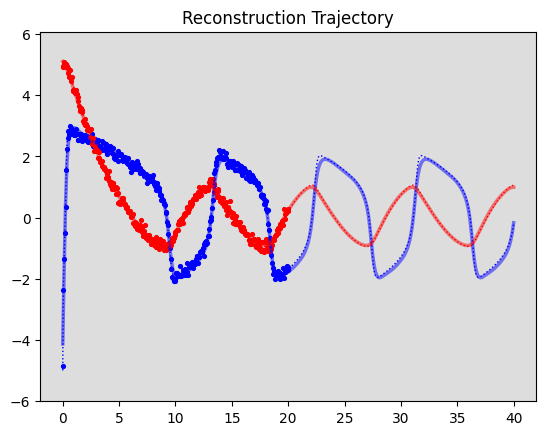

In [10]:
# reconstruction with ode numerical integration from x0
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

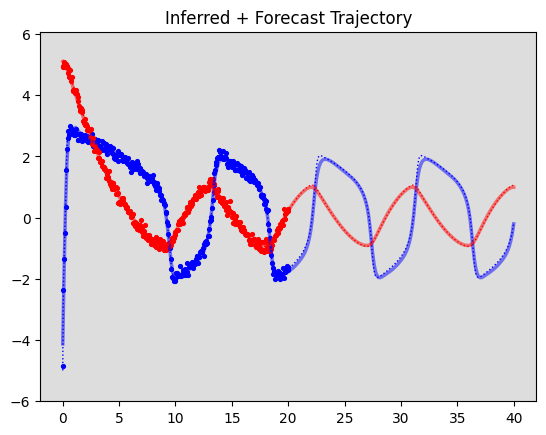

In [11]:
# inferred + forecast with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
tpred = trecon[trecon >= np.max(tinfer)]
tr, xr = model.predict(tpred,tinfer,xinfer,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Inferred + Forecast Trajectory')
plt.show()

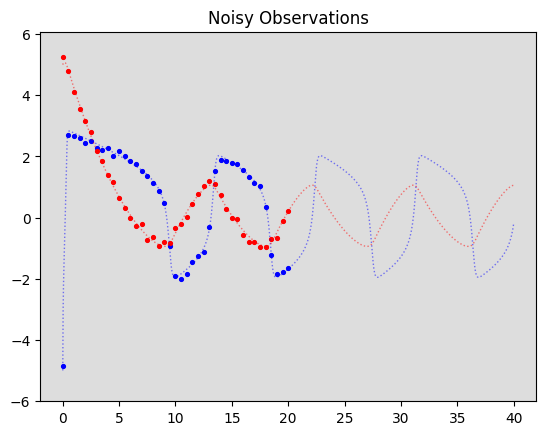

In [12]:
# setting
seed = 188714368 # random seed
noise = [0.1,0.1] # noise level
no_train = 41 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [13]:
# MAP Inference - Multi-task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 22.969542
200/1000 iteration: 2.302366
400/1000 iteration: 1.524019
600/1000 iteration: 1.229117
800/1000 iteration: 1.086559
1000/1000 iteration: 1.008165
run time: 16.64 seconds


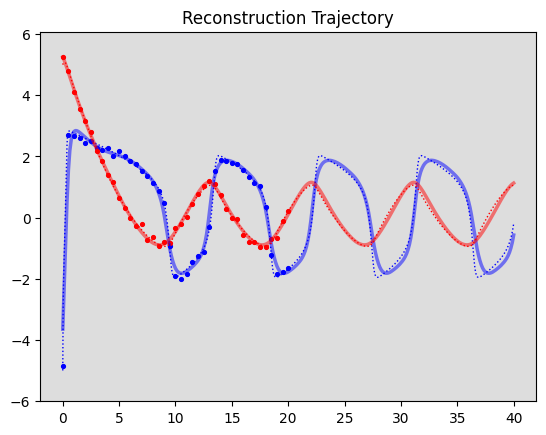

In [14]:
# reconstruction with ode numerical integration from x0
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

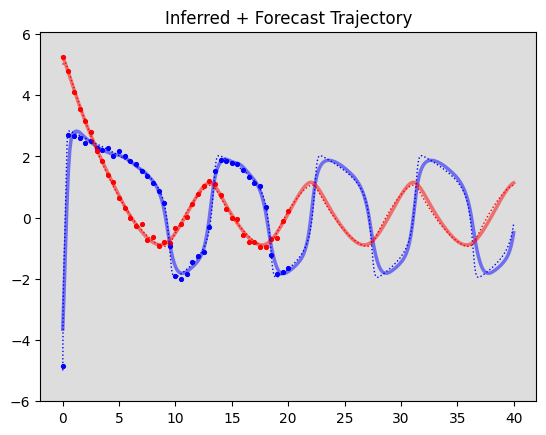

In [15]:
# inferred + forecast with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
tpred = trecon[trecon >= np.max(tinfer)]
tr, xr = model.predict(tpred,tinfer,xinfer,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Inferred + Forecast Trajectory')
plt.show()

### Hes1

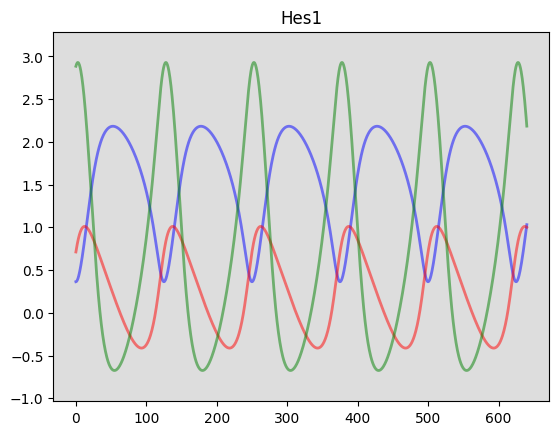

In [16]:
# define Hes1 model dynamic
def fOde(y, t, a, b, c, d, e, f, g):
	P, M, H = y
	dPdt = -a*P*H + b*M - c*P
	dMdt = -d*M + e/(1+np.power(P,2))
	dHdt = -a*P*H + f/(1+np.power(P,2)) - g*H
	return (dPdt,dMdt,dHdt)

# model parameters
a, b, c, d, e, f, g = 0.022, 0.3, 0.031, 0.028, 0.5, 20, 0.3
# initial condition
P0, M0, R0 = 1.438575, 2.037488, 17.90385
y0 = P0, M0, R0
# time point for evaluation
tdata = np.linspace(0, 640, 1281)
# integration 
xdata = odeint(fOde, y0, tdata, args = (a,b,c,d,e,f,g))
xdata = np.log(xdata)

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(tdata, xdata[:,0], 'b', alpha=0.5, lw=2, label='P')
ax.plot(tdata, xdata[:,1], 'r', alpha=0.5, lw=2, label='M')
ax.plot(tdata, xdata[:,2], 'g', alpha=0.5, lw=2, label='H')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Hes1')
plt.show()

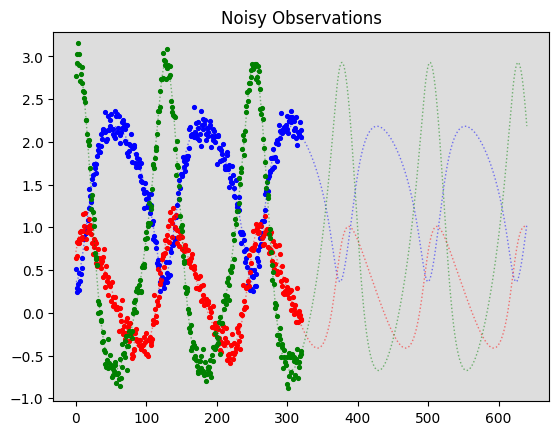

In [17]:
# setting
seed = 188714368 # random seed
noise = [0.10,0.10,0.10] # noise level
no_train = 321 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [18]:
# MAP Inference - Multi-Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=False,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 5.556461
200/1000 iteration: 3.012365
400/1000 iteration: 2.438527
600/1000 iteration: 2.243702
800/1000 iteration: 2.166942
1000/1000 iteration: 2.131362
run time: 26.84 seconds


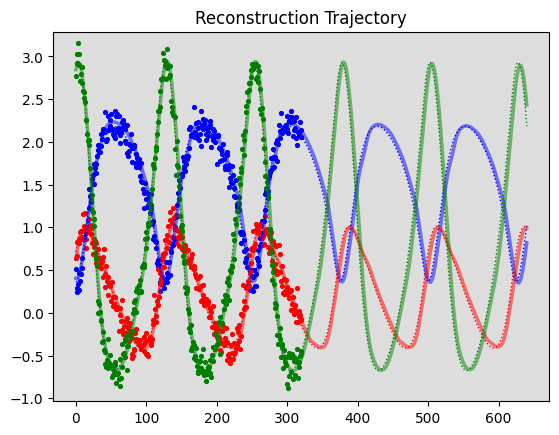

In [19]:
# reconstruction with ode numerical integration from x0
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

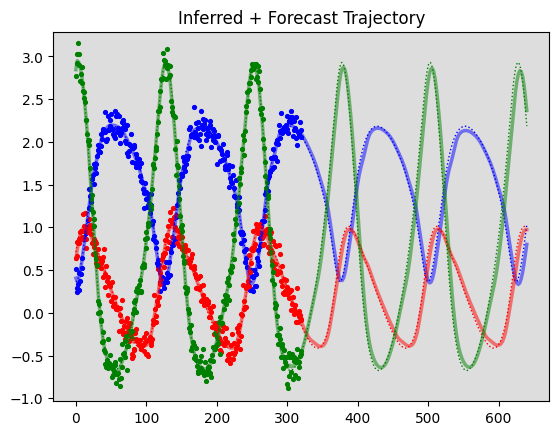

In [20]:
# inferred + forecast with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
tpred = trecon[trecon >= np.max(tinfer)]
tr, xr = model.predict(tpred,tinfer,xinfer,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Inferred + Forecast Trajectory')
plt.show()

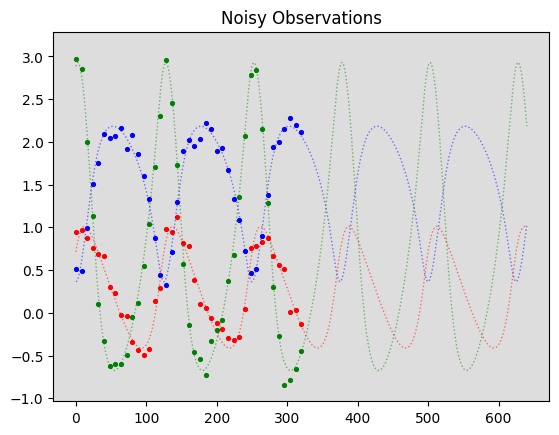

In [21]:
# setting
seed = 188714368 # random seed
noise = [0.10,0.10,0.10] # noise level
no_train = 41 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [27]:
# MAP Inference - Multi-Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=False,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 15.356447
200/1000 iteration: 3.700120
400/1000 iteration: 2.536748
600/1000 iteration: 2.242268
800/1000 iteration: 2.115360
1000/1000 iteration: 2.032695
run time: 22.68 seconds


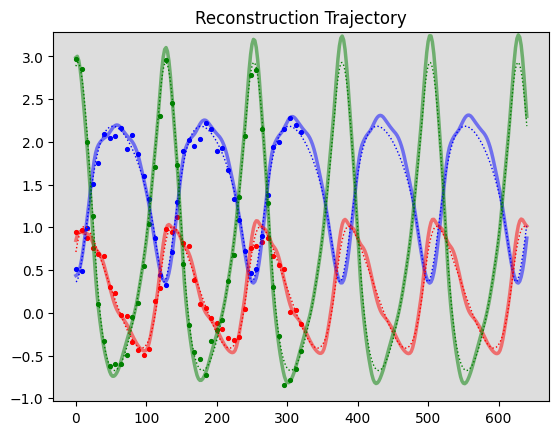

In [28]:
# reconstruction with ode numerical integration from x0
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

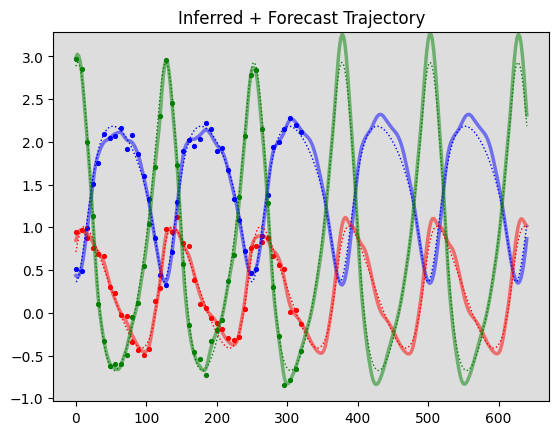

In [29]:
# inferred + forecast with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
tpred = trecon[trecon >= np.max(tinfer)]
tr, xr = model.predict(tpred,tinfer,xinfer,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Inferred + Forecast Trajectory')
plt.show()

### Lorenz 96

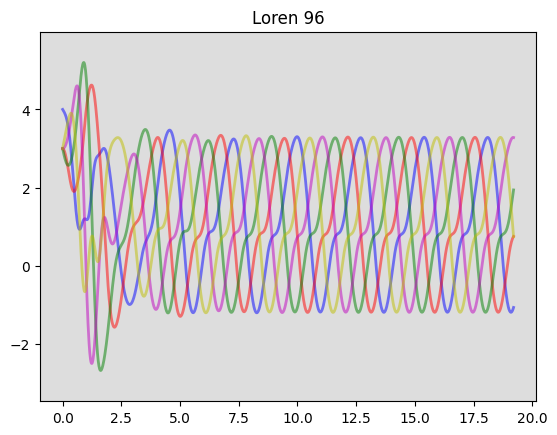

In [30]:
def L96(y, t, F):
    """Lorenz 96 model with constant forcing"""
    N = y.size
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (y[(i + 1) % N] - y[i - 2]) * y[i - 1] - y[i] + F
    return d

# model parameters
F = 3
# initial conditions
y0 = F * np.ones(5)  # Initial state (equilibrium)
y0[0] += 1.0  # Add small perturbation to the first variable
# time point for evaluation
tdata = np.linspace(0.0, 19.2, 1281)
# integration 
xdata = odeint(L96, y0, tdata, args=(F,))

# visualize the groundtruth trajectory
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(xdata.shape[1]):
    ax.plot(tdata, xdata[:,i], color=col[i], alpha=0.5, lw=2)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Loren 96')
plt.show()

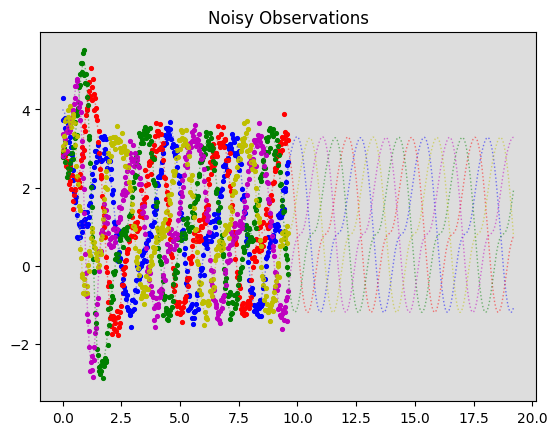

In [31]:
# setting
seed = 188714368 # random seed
noise = [0.2] * xdata.shape[1] # noise level
no_train = 321 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [33]:
# MAP Inference - Multi-Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0.0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 29.881064
200/1000 iteration: 9.023293
400/1000 iteration: 5.690324
600/1000 iteration: 4.525343
800/1000 iteration: 4.027912
1000/1000 iteration: 3.788589
run time: 40.62 seconds


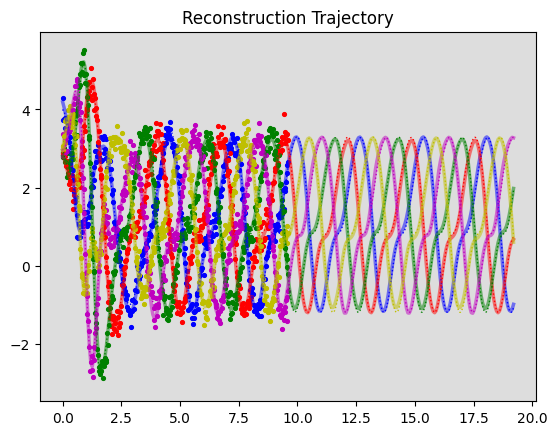

In [34]:
# reconstruction with ode numerical integration from x0
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

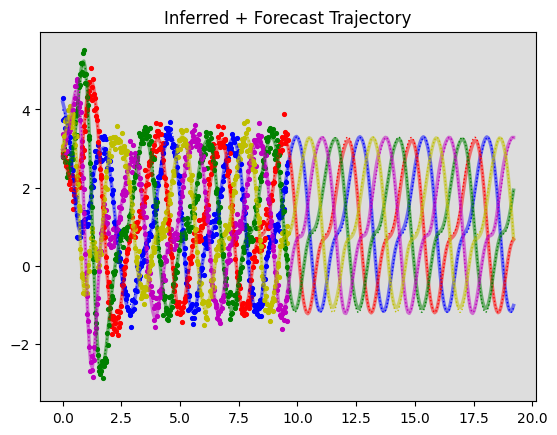

In [35]:
# inferred + forecast with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
tpred = trecon[trecon >= np.max(tinfer)]
tr, xr = model.predict(tpred,tinfer,xinfer,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Inferred + Forecast Trajectory')
plt.show()

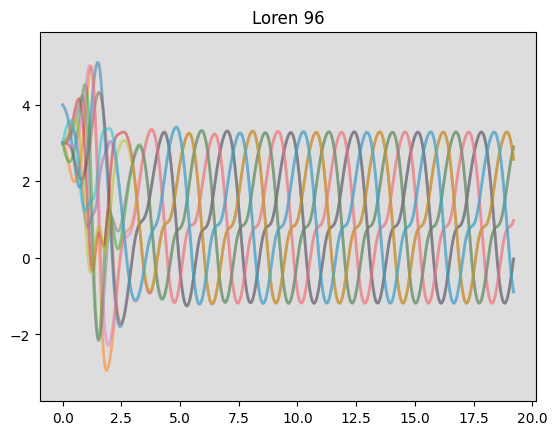

In [37]:
def L96(y, t, F):
    """Lorenz 96 model with constant forcing"""
    N = y.size
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (y[(i + 1) % N] - y[i - 2]) * y[i - 1] - y[i] + F
    return d

# model parameters
F = 3
# initial conditions
y0 = F * np.ones(10)  # Initial state (equilibrium)
y0[0] += 1.0  # Add small perturbation to the first variable
# time point for evaluation
tdata = np.linspace(0.0, 19.2, 1281)
# integration 
xdata = odeint(L96, y0, tdata, args=(F,))

# visualize the groundtruth trajectory
col = list(mcolors.TABLEAU_COLORS.values())
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(xdata.shape[1]):
    ax.plot(tdata, xdata[:,i], color=col[i], alpha=0.5, lw=2)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Loren 96')
plt.show()

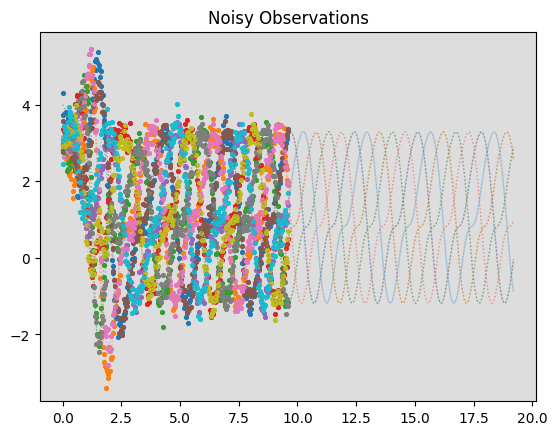

In [40]:
# setting
seed = 188714368 # random seed
noise = [0.2] * xdata.shape[1] # noise level
no_train = 321 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = list(mcolors.TABLEAU_COLORS.values())
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [48]:
# MAP Inference - Multi-Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0.0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 48.314856
200/1000 iteration: 14.229198
400/1000 iteration: 9.202411
600/1000 iteration: 7.669826
800/1000 iteration: 7.078608
1000/1000 iteration: 6.818216
run time: 76.99 seconds


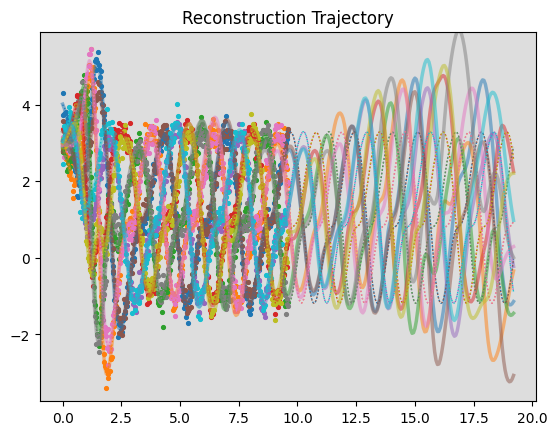

In [49]:
# reconstruction with ode numerical integration from x0
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = list(mcolors.TABLEAU_COLORS.values())
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

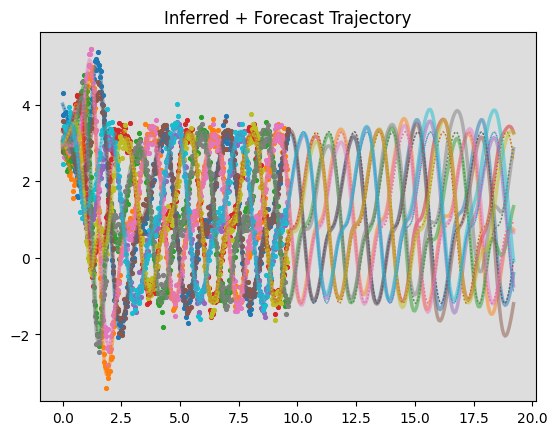

In [50]:
# inferred + forecast with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
tpred = trecon[trecon >= np.max(tinfer)]
tr, xr = model.predict(tpred,tinfer,xinfer,random=False) # reconstructed trajectory
# visualization
col = list(mcolors.TABLEAU_COLORS.values())
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Inferred + Forecast Trajectory')
plt.show()

### ILI

In [51]:
ili = pd.read_csv("data/national_illness_region.csv")
ili.head()

,date,weighted_ili_National,weighted_ili_Region 1,weighted_ili_Region 2,weighted_ili_Region 3,weighted_ili_Region 4,weighted_ili_Region 5,weighted_ili_Region 6,weighted_ili_Region 7,weighted_ili_Region 8,...,unweighted_ili_Region 1,unweighted_ili_Region 2,unweighted_ili_Region 3,unweighted_ili_Region 4,unweighted_ili_Region 5,unweighted_ili_Region 6,unweighted_ili_Region 7,unweighted_ili_Region 8,unweighted_ili_Region 9,unweighted_ili_Region 10
0,9/28/1997,1.10148,0.498535,0.374963,1.354280,0.400338,1.229260,1.01898,0.871791,0.516017,...,0.623848,0.384615,1.34172,0.450010,0.901266,0.747384,1.152860,0.422654,2.25878,4.825400
1,10/5/1997,1.20007,0.642669,0.315666,1.479780,1.423890,1.136000,1.44932,0.449154,0.503080,...,0.815801,0.229358,1.53285,0.389036,1.081310,0.877193,0.647948,0.717703,2.56626,3.959130
2,10/12/1997,1.37876,2.899080,0.310564,2.635980,0.966721,1.023580,1.46230,0.346781,0.176081,...,1.225840,0.127226,2.18735,0.467532,1.064500,0.899550,0.607477,0.246711,2.41531,2.175970
3,10/19/1997,1.19920,4.812500,0.325144,1.983990,0.574446,0.806177,1.64702,0.647388,0.796463,...,1.621690,0.223714,1.69761,0.169525,1.001620,1.059000,0.688172,0.417537,2.64035,0.609418
4,10/26/1997,1.65618,1.371360,3.758060,0.750464,1.224550,1.096170,2.46072,0.492672,0.186496,...,0.780165,2.886600,1.05062,0.474247,1.349670,1.694920,0.500835,0.345871,3.15138,1.114650


<AxesSubplot:xlabel='date'>

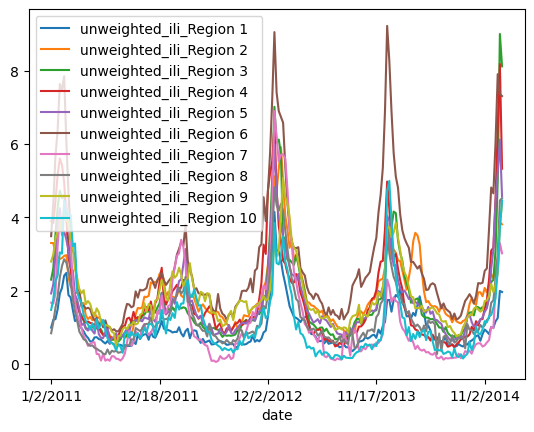

In [52]:
# 2011 - 2014
ili_sub = ili.iloc[692:901,:].copy().reset_index(drop=True)
ili_sub.plot(x='date', y=[f'unweighted_ili_Region {i}' for i in range(1,11)])

In [76]:
# first two year for training, unweighted 
tmax = len(ili_sub)
tdata = np.arange(tmax)
xdata_10 = ili_sub.iloc[:tmax,13:23].to_numpy()
xdata = np.zeros((len(xdata_10),4))
xdata[:,0] = np.mean(xdata_10[:,[0,1,2]], axis=1) # northeast
xdata[:,1] = np.mean(xdata_10[:,[4,6]], axis=1) # midwest
xdata[:,2] = np.mean(xdata_10[:,[3,5]], axis=1) # south
xdata[:,3] = np.mean(xdata_10[:,[7,8,9]], axis=1) # west
xdata = np.log(xdata)
no_comp = xdata.shape[1]
tmax_train = 150 # 105
obs = [] # set random seed for noise
for i in range(no_comp):
    tobs = tdata[:tmax_train].copy()
    yobs = xdata[:tmax_train,i].copy()
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))

In [77]:
# MAP Inference - Multi Task Neural Network
seed = 188714368
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0.0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=201,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=2000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=True, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/2000 iteration: 98.500883
400/2000 iteration: 16.133159
800/2000 iteration: 9.266745
1200/2000 iteration: 7.320846
1600/2000 iteration: 6.481387
2000/2000 iteration: 6.014690
run time: 98.79 seconds


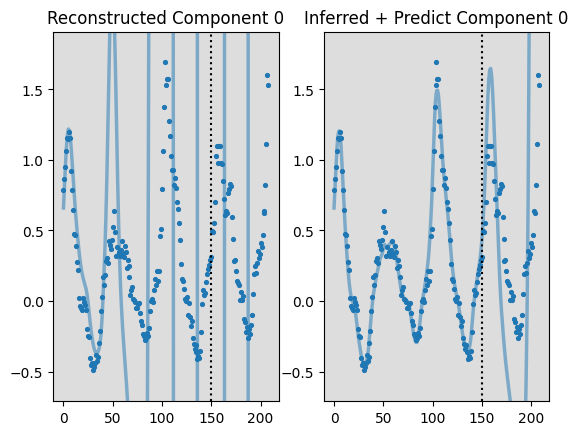

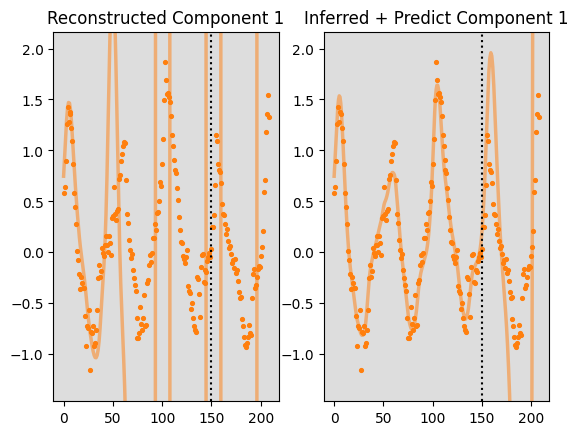

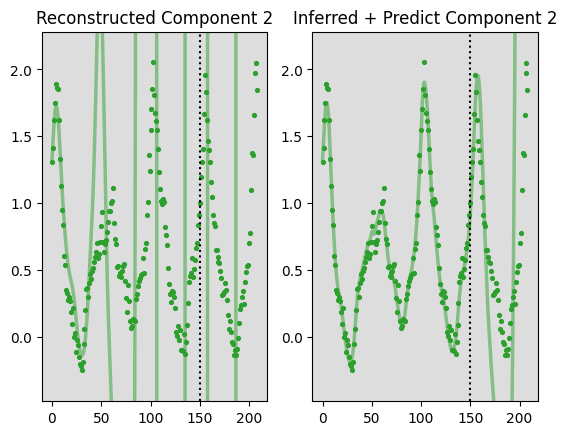

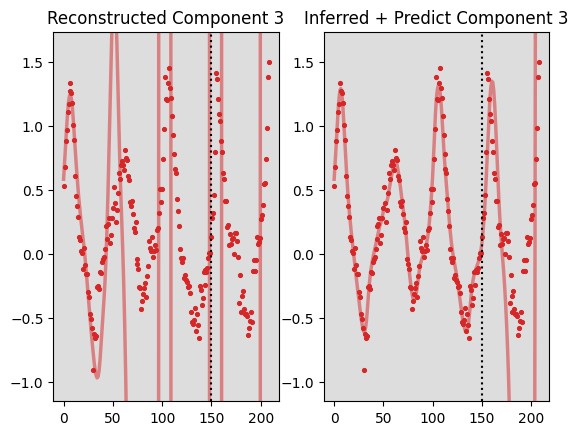

In [78]:
# reconstruction with ode numerical integration
trecon = tdata
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
tpred = tdata[tmax_train:]
tp, xp = model.predict(tpred,tinfer,xinfer,random=False) # reconstructed trajectory
col = list(mcolors.TABLEAU_COLORS.values())
for i in range(no_comp):
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(121, facecolor='#dddddd', axisbelow=True)
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.scatter(tdata, xdata[:,i], s=7.5, marker='o', color=col[i])
    ax.axvline(x=tmax_train, linestyle=':', color='k')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(np.min(xdata[:,i])-0.1*np.ptp(xdata[:,i]),np.max(xdata[:,i])+0.1*np.ptp(xdata[:,i]))
    plt.title(f'Reconstructed Component {i}')
    ax = fig.add_subplot(122, facecolor='#dddddd', axisbelow=True)
    ax.plot(tp, xp[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.scatter(tdata, xdata[:,i], s=7.5, marker='o', color=col[i])
    ax.axvline(x=tmax_train, linestyle=':', color='k')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(np.min(xdata[:,i])-0.1*np.ptp(xdata[:,i]),np.max(xdata[:,i])+0.1*np.ptp(xdata[:,i]))
    plt.title(f'Inferred + Predict Component {i}')
    plt.show()

/tmp/ipykernel_2571253/1591210129.py:11: RuntimeWarning: overflow encountered in exp
  ax.plot(tr, np.exp(xr[:,i]), color=col[i], alpha=0.5, lw=2.5)


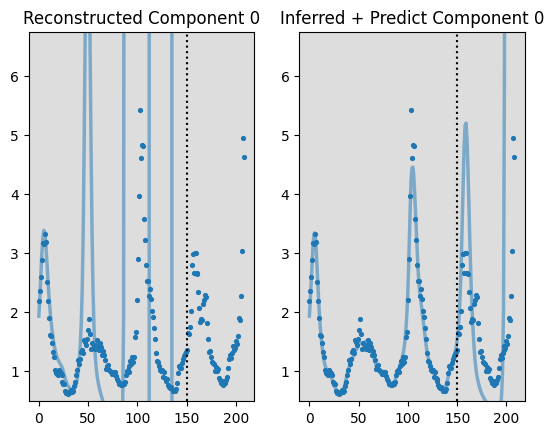

/tmp/ipykernel_2571253/1591210129.py:11: RuntimeWarning: overflow encountered in exp
  ax.plot(tr, np.exp(xr[:,i]), color=col[i], alpha=0.5, lw=2.5)


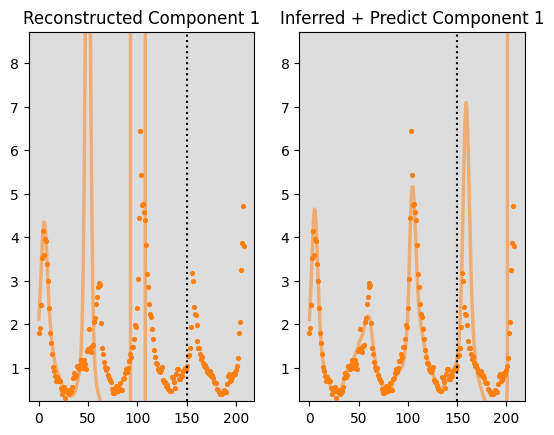

/tmp/ipykernel_2571253/1591210129.py:11: RuntimeWarning: overflow encountered in exp
  ax.plot(tr, np.exp(xr[:,i]), color=col[i], alpha=0.5, lw=2.5)


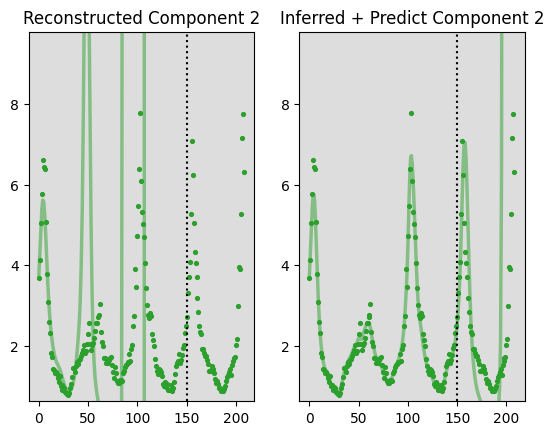

/tmp/ipykernel_2571253/1591210129.py:11: RuntimeWarning: overflow encountered in exp
  ax.plot(tr, np.exp(xr[:,i]), color=col[i], alpha=0.5, lw=2.5)


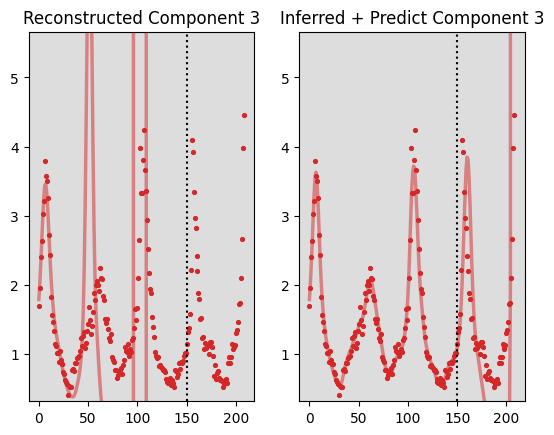

In [79]:
# reconstruction with ode numerical integration
trecon = tdata
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
tpred = tdata[tmax_train:]
tp, xp = model.predict(tpred,tinfer,xinfer,random=False) # reconstructed trajectory
col = list(mcolors.TABLEAU_COLORS.values())
for i in range(no_comp):
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(121, facecolor='#dddddd', axisbelow=True)
    ax.plot(tr, np.exp(xr[:,i]), color=col[i], alpha=0.5, lw=2.5)
    ax.scatter(tdata, np.exp(xdata[:,i]), s=7.5, marker='o', color=col[i])
    ax.axvline(x=tmax_train, linestyle=':', color='k')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(np.exp(np.min(xdata[:,i])-0.1*np.ptp(xdata[:,i])),np.exp(np.max(xdata[:,i])+0.1*np.ptp(xdata[:,i])))
    plt.title(f'Reconstructed Component {i}')
    ax = fig.add_subplot(122, facecolor='#dddddd', axisbelow=True)
    ax.plot(tp, np.exp(xp[:,i]), color=col[i], alpha=0.5, lw=2.5)
    ax.scatter(tdata, np.exp(xdata[:,i]), s=7.5, marker='o', color=col[i])
    ax.axvline(x=tmax_train, linestyle=':', color='k')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(np.exp(np.min(xdata[:,i])-0.1*np.ptp(xdata[:,i])),np.exp(np.max(xdata[:,i])+0.1*np.ptp(xdata[:,i])))
    plt.title(f'Inferred + Predict Component {i}')
    plt.show()